## Import Libaries

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings

In [32]:
filterwarnings('ignore')

## Import dataset

In [2]:
data = pd.read_csv('./fake-news/train.csv', index_col="id")
data.head()

,title,author,text,label
id,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


### `0` : reliable
### `1` : fake

## Data pre-processing

### Drop duplicate titles

In [3]:
data.drop_duplicates(subset='title', keep='first', inplace=True)

### Drop NA values

In [4]:
data.dropna(subset="title", inplace = True)

## Feature Engineering

In [5]:
data = data[['title', 'label']]

## Text cleaning

In [6]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [7]:
import re

In [8]:
from unidecode import unidecode

In [9]:
import nltk
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

In [10]:
def clean_text(text):
    text = text.lower()
    text = re.sub('[0-9]', '', text)
    text = [unidecode(word.lemma_) for word in nlp(text) if unidecode(word.lemma_) not in stop_words]
    text = ' '.join(text)
    text = re.sub('[!"#$%&()*+,-/:;<=>?@[\\]\'\"^_`{|}~]', '', text)
    text = re.sub('[\n\t]', ' ', text)
    text = [word for word in text.split() if len(word)>1]
    return ' '.join(text)


In [11]:
data['title'] = data['title'].apply(clean_text)

#### Remove empty text

In [12]:
data = data[~data['title'].str.isspace()]

In [13]:
data = data[~data['title'].apply(lambda x : not(x))]

#### Drop duplicates

In [47]:
data.drop_duplicates(keep='first', inplace=True)

### Word CLoud

In [48]:
whole_text = ""
for token in data['title'].values:
    whole_text += token

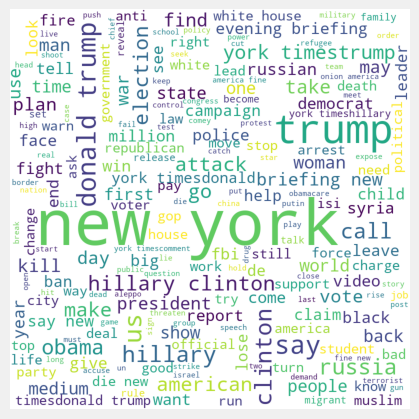

In [49]:
from wordcloud import WordCloud

wordcloud2 = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(whole_text)
 
plt.figure(figsize = (4, 4), facecolor = None)
plt.imshow(wordcloud2)
plt.axis("off")
plt.tight_layout(pad = 0)

### Title length frequency distribution

In [30]:
plt.style.use('fivethirtyeight')

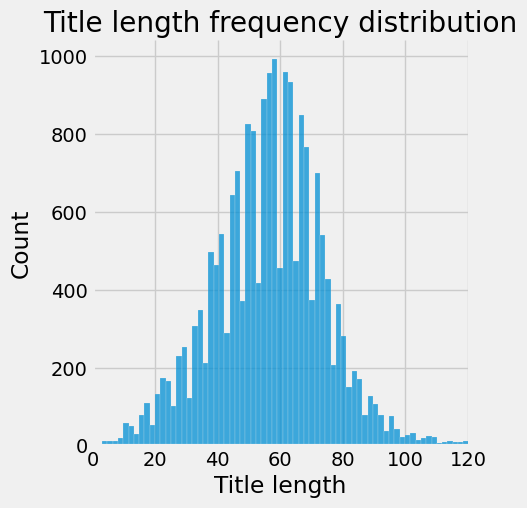

In [53]:
length = data['title'].str.len()
sns.displot(length)
plt.xlim((0, 120))
plt.xlabel("Title length")
plt.title("Title length frequency distribution")
plt.show()

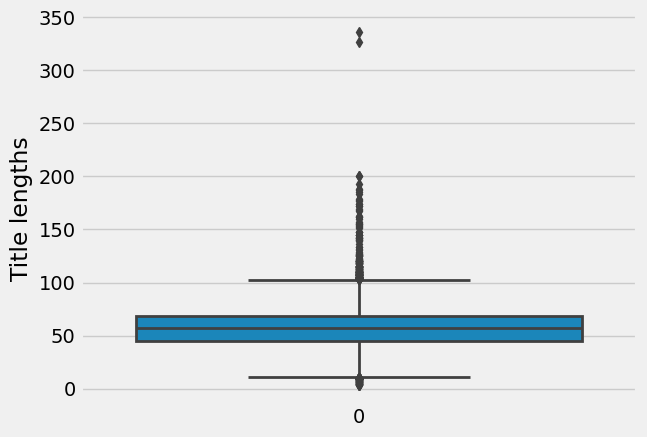

In [54]:
sns.boxplot(length, linewidth=2)
plt.ylabel("Title lengths")
plt.show()

In [55]:
length.describe()

count    19569.000000
mean        56.773519
std         18.482199
min          3.000000
25%         45.000000
50%         57.000000
75%         68.000000
max        336.000000
Name: title, dtype: float64

#### The approximate title length for all the title is chosen as `50`

In [241]:
seq_len = 50

### Feature and Label

In [242]:
X = data.title.values
y = data.label.values

## Tokenization

In [243]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [244]:
vocab_size = len(tokenizer.index_word)

In [245]:
X = tokenizer.texts_to_sequences(X)

## Pad sequences

In [246]:
from keras.utils import pad_sequences
X = pad_sequences(X, maxlen=seq_len, truncating='post', padding='post')

In [247]:
X[0]

array([  33,  230,  638,  300,   74,   97,  494, 1480, 2909,  401,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

## Train Test set split

In [248]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [249]:
X_train[2]

array([ 947, 2010,    4,  401,  553, 1443,   95,  230,   24,    5,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

In [250]:
y_train[2]

0

## LSTM

In [251]:
from keras import Sequential
from keras.layers import Embedding, Dense, LSTM

In [252]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size+1, output_dim=50, input_length=seq_len))
model.add(LSTM(units = 128))
model.add(Dense(units = 1, activation='sigmoid'))

In [253]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 50, 50)            894350    
                                                                 
 lstm_14 (LSTM)              (None, 128)               91648     
                                                                 
 dense_14 (Dense)            (None, 1)                 129       
                                                                 
Total params: 986127 (3.76 MB)
Trainable params: 986127 (3.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [254]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [255]:
model.fit(x = X_train, y = y_train, validation_data = (X_test, y_test), batch_size=32, epochs=7)

Epoch 1/7


459/459 [==============================] - 25s 50ms/step - loss: 0.5776 - accuracy: 0.6481 - val_loss: 0.4251 - val_accuracy: 0.8077
Epoch 2/7
459/459 [==============================] - 22s 47ms/step - loss: 0.5639 - accuracy: 0.6875 - val_loss: 0.6113 - val_accuracy: 0.6354
Epoch 3/7
459/459 [==============================] - 22s 48ms/step - loss: 0.5882 - accuracy: 0.6630 - val_loss: 0.6121 - val_accuracy: 0.6370
Epoch 4/7
459/459 [==============================] - 21s 46ms/step - loss: 0.5805 - accuracy: 0.6868 - val_loss: 0.4064 - val_accuracy: 0.8698
Epoch 5/7
459/459 [==============================] - 20s 43ms/step - loss: 0.2179 - accuracy: 0.9230 - val_loss: 0.1885 - val_accuracy: 0.9324
Epoch 6/7
459/459 [==============================] - 19s 42ms/step - loss: 0.0919 - accuracy: 0.9707 - val_loss: 0.2197 - val_accuracy: 0.9264
Epoch 7/7
459/459 [==============================] - 19s 42ms/step - loss: 0.0580 - accuracy: 0.9841 - val_loss: 0.2321 - val_accuracy: 0.9315


In [256]:
model.save("fake_news_detector2.keras")     # Don't change the file name

In [273]:
from keras.models import load_model
model = load_model('fake_news_detector.keras')     # This is the actual model

## Model evaluation

In [279]:
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, confusion_matrix

In [275]:
y_pred = model.predict(X_test)

153/153 [==============================] - 3s 15ms/step


In [276]:
for i,pred in enumerate(y_pred):
    if(pred[0]>0.5):
        y_pred[i]=1
    else:
        y_pred[i]=0

In [277]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      2569
           1       0.91      0.95      0.93      2324

    accuracy                           0.93      4893
   macro avg       0.93      0.93      0.93      4893
weighted avg       0.93      0.93      0.93      4893



In [278]:
print(f"Accuracy score : {accuracy_score(y_test, y_pred):.3f}")
print(f"Recall score : {recall_score(y_test, y_pred):.3f}")
print(f"Precision score : {precision_score(y_test, y_pred):.3f}")

Accuracy score : 0.932
Recall score : 0.954
Precision score : 0.907


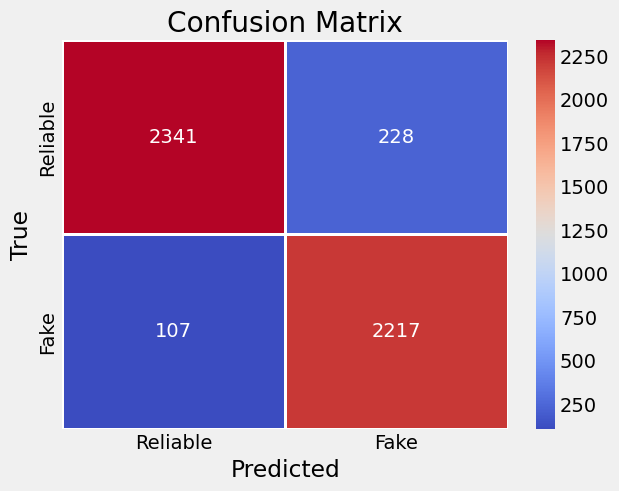

In [298]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt = '.0f', cmap = 'coolwarm', linewidths=1)
plt.xticks((0.5, 1.5), labels=("Reliable", "Fake"))
plt.yticks((1.5, 0.5), labels=("Fake", "Reliable"))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()